In [118]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

# Data Gathering

In [131]:
df=pd.read_csv(r"E:\10.python\Time Series\ts_data_set\daily-minimum-temperatures-in-me.csv")

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        3650 non-null   object
 1   Daily minimum temperatures  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


# Daily minimum temperatures

In [ ]:
# In this column are some noise and datatype is object

In [133]:
def target_datatype(string):
    if type(string)==str:
        a=string.replace("?","")
        return eval(a)
    else:
        return string
df["Daily minimum temperatures"]=df["Daily minimum temperatures"].apply(target_datatype)

In [135]:
df["Date"]=pd.to_datetime(df["Date"])

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        3650 non-null   datetime64[ns]
 1   Daily minimum temperatures  3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


In [137]:
df.set_index("Date",inplace=True)

# converting Daily data into Monthly

In [138]:
df=df.resample("M").mean()

In [139]:
df.columns=["Daily_minimum_temperatures"]

In [140]:
df

,Daily_minimum_temperatures
Date,
1981-01-31,17.712903
1981-02-28,17.678571
1981-03-31,13.500000
1981-04-30,12.356667
1981-05-31,9.490323
...,...
1990-08-31,7.825806
1990-09-30,9.166667
1990-10-31,11.345161


# test_stationarity

In [141]:
from statsmodels.tsa.stattools import adfuller
x = df['Daily_minimum_temperatures'].values
result = adfuller(x)
print('Pvalue : ', round(result[1],4))
print('ADF Statistics:', round(result[0],3))
for key, value in result[4].items():
    print('\t:',key,value)

Pvalue :  0.3357
ADF Statistics: -1.892
	: 1% -3.4936021509366793
	: 5% -2.8892174239808703
	: 10% -2.58153320754717


In [142]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.05):
    import matplotlib.pyplot as plt
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

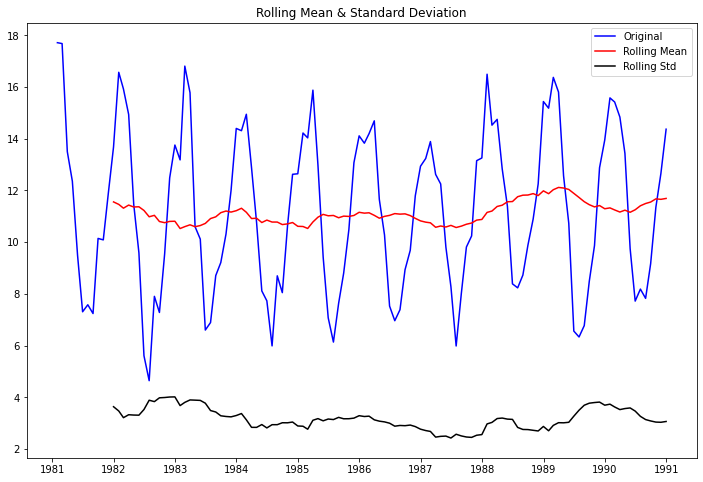

Results of Dickey-Fuller Test:
p-value = 0.5308. The series is likely non-stationary.
Test Statistic                  -1.505564
p-value                          0.530757
#Lags Used                      11.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


In [143]:
test_stationarity(df["Daily_minimum_temperatures"])

<AxesSubplot:xlabel='Date'>

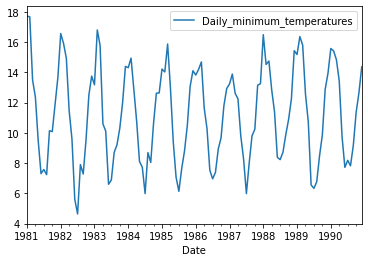

In [144]:
df.plot()

# seasonal_decompose

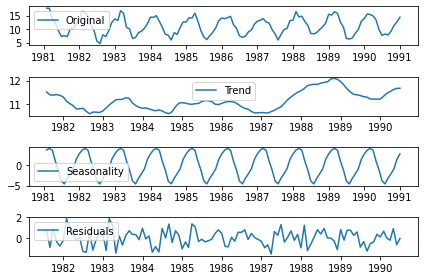

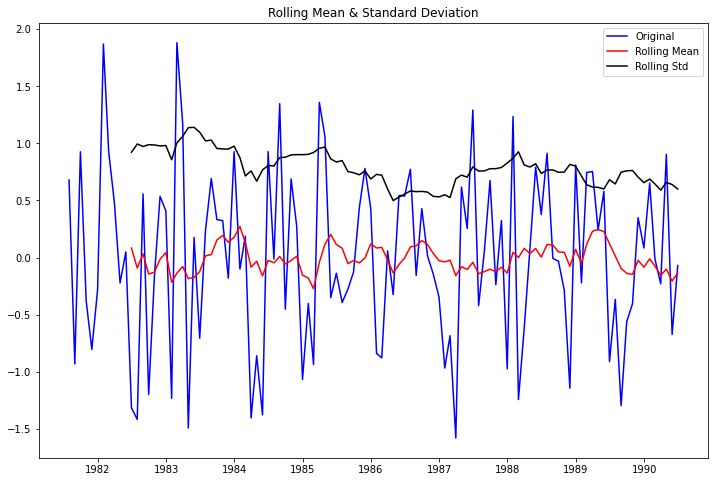

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.073188e+00
p-value                        4.877110e-10
#Lags Used                     5.000000e+00
Number of Observations Used    1.020000e+02
Critical Value (1%)           -3.496149e+00
Critical Value (5%)           -2.890321e+00
Critical Value (10%)          -2.582122e+00
dtype: float64


In [145]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Daily_minimum_temperatures'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df['Daily_minimum_temperatures'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

decomposed_log_data = residual
decomposed_log_data.dropna(inplace=True)
test_stationarity(decomposed_log_data)

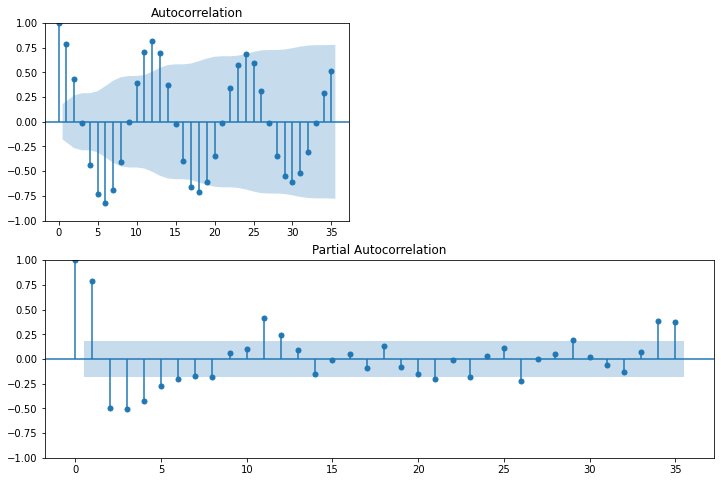

In [146]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(df['Daily_minimum_temperatures'],lags=35,ax=ax1)
ax2=fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Daily_minimum_temperatures'],lags=35,ax=ax2)

In [147]:
# q==3 , p==2

In [ ]:
# Tuning to find best value of p,d,q

In [148]:
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
# series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
series= df['Daily_minimum_temperatures']
# evaluate parameters
p_values = range(2,3)
d_values = range(0, 2)
q_values = range(2, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)


ARIMA(2, 0, 2) RMSE=0.992
ARIMA(2, 0, 3) RMSE=1.081
ARIMA(2, 1, 2) RMSE=1.171
ARIMA(2, 1, 3) RMSE=0.998
Best ARIMA(2, 0, 2) RMSE=0.992


In [149]:
#train test split

In [150]:
fig = px.line(df, x=df.index, y='Daily_minimum_temperatures', hover_data=['Daily_minimum_temperatures'], title='Monthly Avg. Temp')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [151]:
df.shape

(120, 1)

In [152]:
y_train = df['Daily_minimum_temperatures'][:90]
y_test  = df['Daily_minimum_temperatures'][90:]

# ARIMA

In [153]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train, order= (2,0,2))
result_ar = model.fit()

<AxesSubplot:xlabel='Date'>

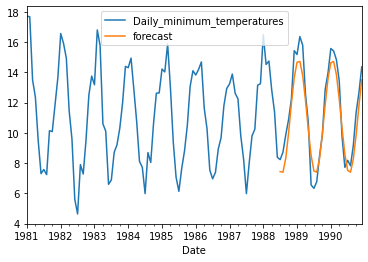

In [154]:
df['forecast'] = result_ar.predict(start =90, end =120 )
df[['Daily_minimum_temperatures','forecast']].plot()

In [155]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1]+ DateOffset(months=i) for i in range(25)]
future_dates_df = pd.DataFrame(index= future_dates[1:], columns=df.columns)
future_dataframe = pd.concat([df, future_dates_df])
future_dataframe

,Daily_minimum_temperatures,forecast
1981-01-31,17.712903,NaN
1981-02-28,17.678571,NaN
1981-03-31,13.5,NaN
1981-04-30,12.356667,NaN
1981-05-31,9.490323,NaN
...,...,...
1992-08-31,NaN,NaN
1992-09-30,NaN,NaN
1992-10-31,NaN,NaN
1992-11-30,NaN,NaN


<AxesSubplot:>

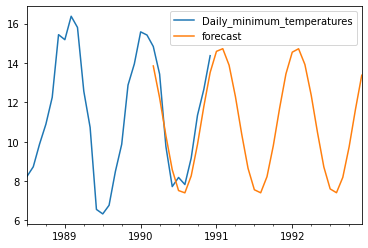

In [156]:
future_dataframe['forecast'] = result_ar.predict(start =110, end =180)
future_dataframe[['Daily_minimum_temperatures','forecast']][90:].plot()

In [157]:
y_pred=df.dropna()
# y_pred=y_pred["forecast"]
# y_test=y_pred["Daily_minimum_temperatures"]
y_pred

,Daily_minimum_temperatures,forecast
Date,,
1988-07-31,8.232258,7.439822
1988-08-31,8.725806,7.402234
1988-09-30,9.883333,8.339154
1988-10-31,10.890323,10.000469
1988-11-30,12.253333,11.943460
1988-12-31,15.436667,13.650784
1989-01-31,15.180645,14.668218
1989-02-28,16.371429,14.725507
1989-03-31,15.803226,13.808144


In [158]:
def MAPE(y_test, y_pred): # mean absolute percentage error
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs(y_test-y_pred)/y_test)*100

In [159]:
MAPE(y_pred["Daily_minimum_temperatures"],y_pred["forecast"])

8.647329529111305

In [160]:
y_train = df['Daily_minimum_temperatures'][:90]
y_test  = df['Daily_minimum_temperatures'][90:]

In [169]:
df

,Daily_minimum_temperatures,forecast
Date,,
1981-01-31,17.712903,NaN
1981-02-28,17.678571,NaN
1981-03-31,13.500000,NaN
1981-04-30,12.356667,NaN
1981-05-31,9.490323,NaN
...,...,...
1990-08-31,7.825806,7.402715
1990-09-30,9.166667,8.261357
1990-10-31,11.345161,9.865159


# SARIMAX

In [170]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(df['Daily_minimum_temperatures'], order = (2,0,2), seasonal_order=(2,0,2,12))
result_sar = sarima.fit()

<AxesSubplot:xlabel='Date'>

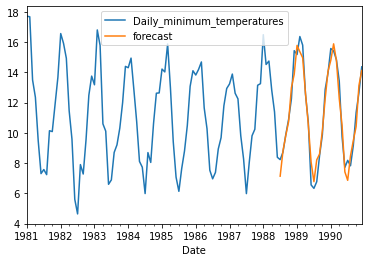

In [171]:
df['forecast'] = result_sar.predict(start = 90, end = 120 )
df[['Daily_minimum_temperatures','forecast']].plot()

<AxesSubplot:>

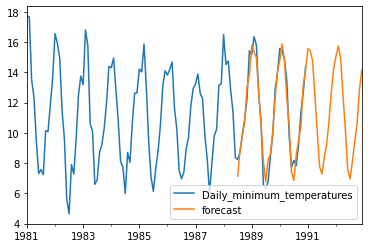

In [178]:
future_dataframe['forecast'] = result_sar.predict(start = 90, end =144 )
future_dataframe[['Daily_minimum_temperatures','forecast']].plot()

In [191]:
y_pr=future_dataframe['forecast'][90:120]
# y_pr

In [189]:
ya=future_dataframe['Daily_minimum_temperatures'][90:120]

In [190]:
MAPE(ya,y_pr)

6.041698998792263

# Model Selection

In [ ]:
MAPE >> ASIMA   >> 8.647329529111305
MAPE >> SARIMAX >> 6.041698998792263

# selected the final model is SARIMAX